In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
from envs.env import *
from pathlib import Path
import pandas as pd
from config import settings
from model_architectures.curator import CuratorNetwork
import pickle
from contextual_ts_testing import *
from IPython.display import clear_output
from tqdm.notebook import tqdm
from constants import *

In [3]:
context_dim = 16
movie_dim = 24

## Prepare Environment

In [4]:
catalog_df = pd.read_parquet("data/whatson_catalog_df.parquet")
historical_data_df = pd.read_pickle("data/historical_data_df.pkl")
with open(settings.aud_model_dir/"rf_model.pkl", "rb") as f:    # load frozen viewership model
    audience_model = pickle.load(f)

In [5]:
env = TVProgrammingEnvironment(movie_catalog=catalog_df,
                         historical_df= historical_data_df,
                         audience_model=audience_model)

Setting up CompetitorDataManager...
Setting up Scalers...
Setting up RewardCalculator...
Setting up ContextualThompsonSampler...
Setting up CuratorNetwork...


## Recommendation loop

In [6]:
dates = create_date_list(10)

In [7]:
chosen_signals = input(prompt=f'If any factors were paricularly helpful in choosing the movie, please write the reward factor name \nChoose from {y_signal_feature_selection}')

Getting candidate features...


Movies:   0%|          | 0/1168 [00:00<?, ?it/s]

Done
525452: score = 0.528
915935: score = 0.515
XF_000_433: score = 0.514
1452795: score = 0.511
1669: score = 0.508

🎬 525452: Orgueil et préjugés  (total score = 0.528) (p = 0.6290968932688857)

 Actors: Matthew Mc Fadyen, Judi Dench, Donald Sutherland, Keira Knightley, Rosamund Pike
  Breakdown:
    • reward_audience                 0.681 ×  0.269 =   0.183 (+)
    • curator_select_prob             0.995 ×  0.182 =   0.181 (+)
    • reward_novelty                  0.750 ×  0.162 =   0.122 (+)
    • reward_diversity                0.300 ×  0.098 =   0.029 (+)
    • reward_rights                   0.100 ×  0.130 =   0.013 (+)

🎬 915935: Anatomie d'une chute   (total score = 0.515) (p = 0.6260322224365831)

 Actors: Sandra Hüller, Swann Arlaud, Milo Machado Graner, Antoine Reinartz
  Breakdown:
    • reward_audience                 0.678 ×  0.269 =   0.182 (+)
    • curator_select_prob             0.999 ×  0.182 =   0.182 (+)
    • reward_novelty                  0.750 ×  0.162 =   0.

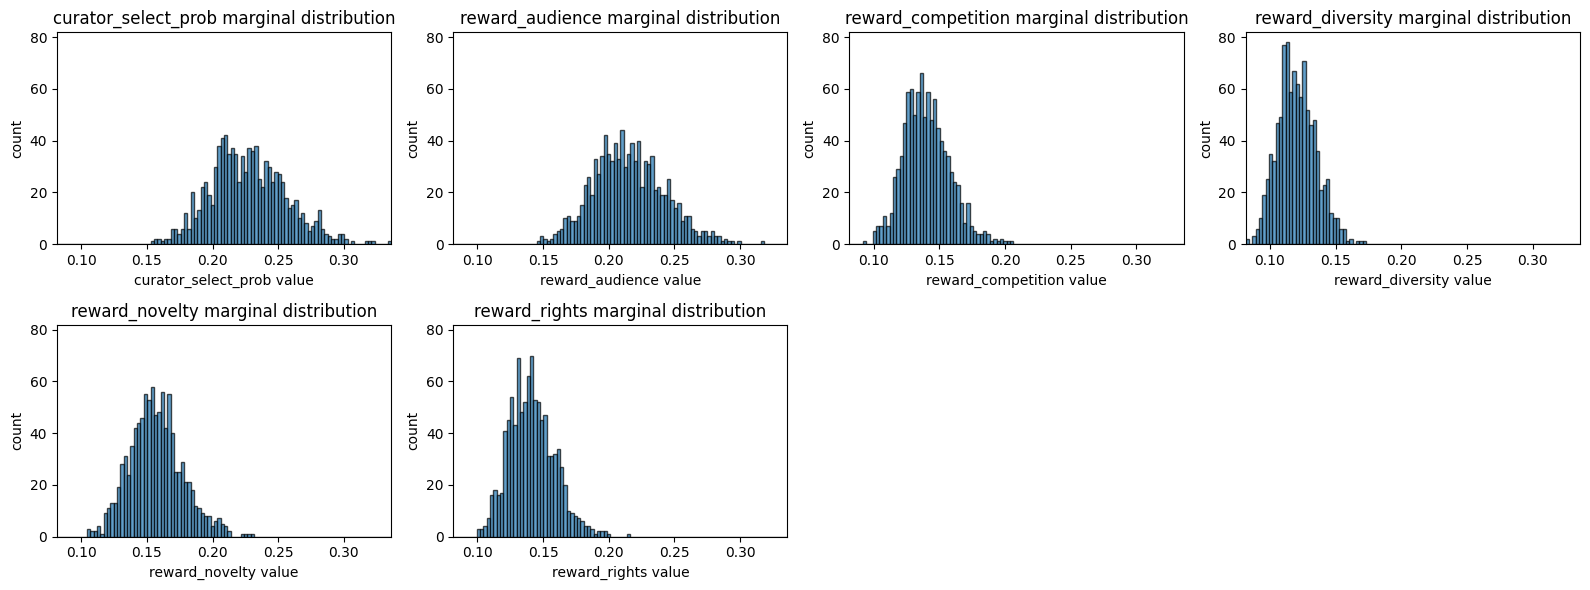

Type go when done analyzing


In [9]:
status = 'go'
for date in tqdm(dates, desc="Dates"):
    if status == 'exit':
            break
    for hour in hours:
        if status == 'exit':
                break
        clear_output(wait=True)
        context_f, context, air_date = env.get_context_features_from_date_hour(date, hour)
        weekday = air_date.strftime("%A")
        day = air_date.strftime('%d')
        month = air_date.strftime('%B')
        year = air_date.strftime('%Y')

        print(f'Context: {hour, weekday, day, month, year}')
        env.get_available_movies(air_date, context)
        recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = env.recommend_n_films(context, air_date)
        env.show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)

        chosen_movie = '-1'
        while chosen_movie == '-1':
            chosen_movie = input(prompt='Choose a movie catalog id, if none are to your liking write -1 ')
            if chosen_movie != '-1':
                chosen_idx = movies.index(chosen_movie)
                chosen_signals = input(prompt=f'If any factors were paricularly helpful in choosing the movie, please write the reward factor name \nChoose from {y_signal_feature_selection}')
                y_signals = env.encode_chosen_signals(chosen_signals)
                print(y_signals)
            else:
                chosen_idx = -1
            
            for idx in top5_idx:
                x_i = X_cands[idx]                   # feature vector for this shown movie

                if idx == chosen_idx:
                    r = 1                            # curator chose it
                else:
                    r = 0                            # curator did *not* choose it

                env.cts.update(context_f, x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x
                param_std = np.sqrt(env.cts.expl_scale / env.cts.h_U)      # same shape as U
                print("Mean param std:", param_std.mean())
                print(f'h_U: {env.cts.h_U.mean()}, h_b: {env.cts.h_b.mean()}')
            fig, axes, samples = marginal_weight_distribution_cts(env.cts, env, num_samples=1000, show=False, bins=100)
            plt.show()
            print('Type go when done analyzing')
            status = input(prompt = 'Type go when done analyzing, type exit to break loop')
            if status == 'exit':
                break
            if chosen_movie == '-1':
                available_movies = [movie for  movie in env.available_movies if movie not in recommended]
                env.available_movies = available_movies
                print(len(env.available_movies))
                clear_output(wait=True)
                recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = env.recommend_n_films(context, air_date)
                print(f'Context: {hour, weekday, day, month, year}')
                env.show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)

        chosen_movie = '-1'

## Save model

In [10]:
env.cts.save(Path("models/ts_state_tick_match.npz"))